In [1]:
%load_ext autoreload
%autoreload 2

## Shapley value defintion
Given a set of n elements, $U := \{1, \cdots, n\}$ and a function

$g: 2^U \rightarrow \mathbb{R}$ with $g(U) \neq 0$, $g(\varnothing)=0$

define $C(j|T) := g(T \cup \{j\}) - g(T)$ with $T \subseteq U$.

Feture i's contribution:

$\phi_i := \sum_{T \subseteq U} \frac{|T|! (n-1-|T|)!}{n!} C(i|T)$

where
$g(T) := f_T(x_T) - f(x')$ with $f_\varnothing(x_\varnothing) = f(x')$ for some baseline $x'$. 

$f_T(x_T) := \mathbb{E}[ f(x_T, X_{\bar{T}}) | z]$  where $z$ is a hyperparameter

previous approaches considers
- unconditional: $z := \varnothing$
- conditional: $z := \{X_T = x_T \}$

we in addition consider using a causal graph
- do: $z := \{do(X_T = x_T)\}$

## Assumptions
- no unobserved confounders

## Axioms

1. Any ordering of the source node is equally likely (eliminate reverse dfs)
2. Expanding a node won't affect the contribution of irrelevant edges (eliminate permutation of path and reverse dfs with single source by revealing the model node)
3. Efficiency
4. Linearity
5. NULL player

Want to show the dfs uniquely satisfies those axioms among path attribution methods. Edge attribution method is induced from the path attribution. 
Note that we don't have symmetry. Also note that axiom 1 may be eliminable.

## Noise distribution

For continuous variables, we assume data is generated through the data generating function with added Gaussian Noise (consistent with the assumption of regression problems).

For categorical variables, we assume the data is generated according to a categorical distribution, we perform inverse probability sampling by sampling from a uniform distribution.

## Efficiency of Shapley Flow

Sampling based Shapley Flow cannot be too efficient compared to sampling based SHAP because flow is based on path. To know the effect of a coalition of paths, we need to
run through the computational graph instead of just taking the corresponding target value due to the existence of intermediate state for a general causal graph. This means it is 
hard to vectorize the alogrithm based on path, but we can vectorize it based on input batch. Indeed, explaining 1000 cases takes similar time as explaining 1 case. 

To make each run more efficient, I can
- parallelize the running
- precompute all the randomness
- evaluate a node only after enough data need to be evaluated at the node (need to deal with mutex and other stuff)

One bottleneck is models seems to run a lot faster with batched input. This should be doable, look into numba for exmaples. The result also may benefit from cacheing.

In [2]:
import sys
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
import networkx as nx
from graphviz import Digraph, Source
from pygraphviz import AGraph
import numpy as np
import matplotlib.image as mpimg
from IPython.display import Image
import matplotlib.pyplot as plt
from flow import Node, CreditFlow, Graph, flatten_graph, eval_graph, get_source_nodes, single_source_graph, boundary_graph, viz_graph, save_graph
from collections import defaultdict

# 0 baseline model

$\text{health status} \in \{0, 1\}$

$\text{portable scanner} \in \{0, 1\}$

$\text{mortality probability prediction} \in [0, 1]$


```python
    x1 = Node('health status')
    n2 = Node('scanner type noise', is_noise_node=True) # U(0, 1)
    x2 = Node('scanner type', lambda x1, n2: int(0.9 > n2) if x1 <= 0.1 else int(0.3 > n2), [x1, n2])
    y  = Node('mortality prediction', lambda x1, x2: x2, 
              [x1, x2], is_target_node=True)
```

sampling:   0%|          | 0/1 [00:00<?, ?it/s]

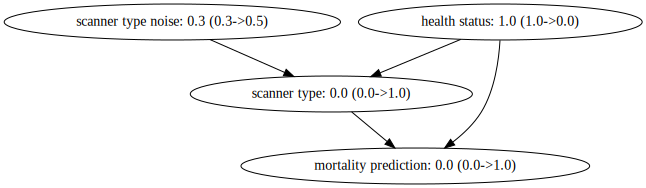


----> using order [scanner type noise, health status]
baselines scanner type noise: 0.3, health status: 1
turn on edge from external source to scanner type noise
scanner type noise changes from 0.3 to 0.5


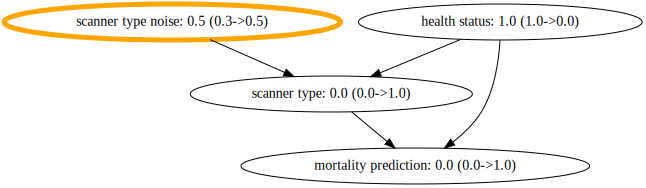

turn on edge scanner type noise->scanner type
scanner type changes from 0 to 0


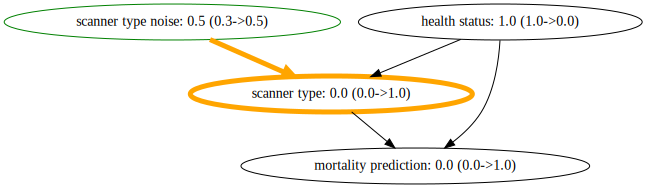

turn on edge scanner type->mortality prediction
mortality prediction changes from 0 to 0


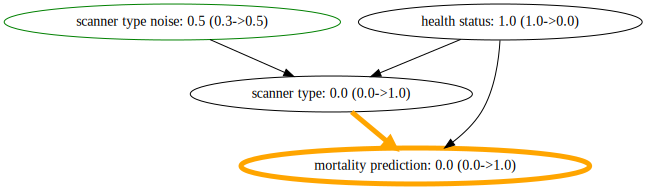

assign 0 credits to scanner type->mortality prediction


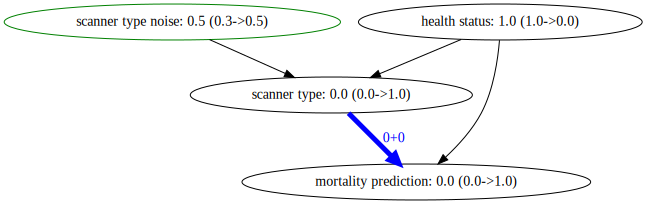

assign 0 credits to scanner type noise->scanner type


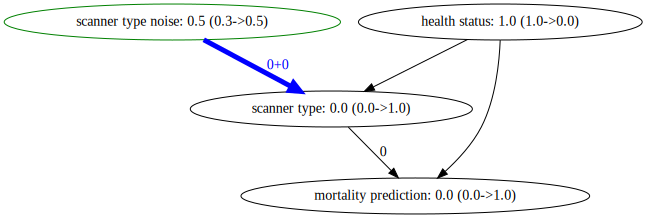

turn on edge from external source to health status
health status changes from 1 to 0


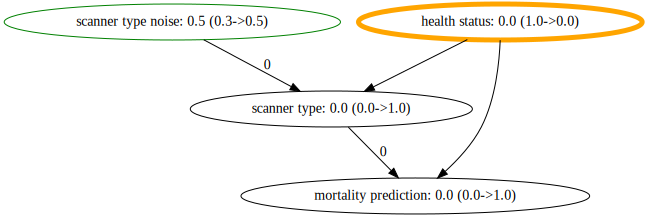

turn on edge health status->mortality prediction
mortality prediction changes from 0 to 0


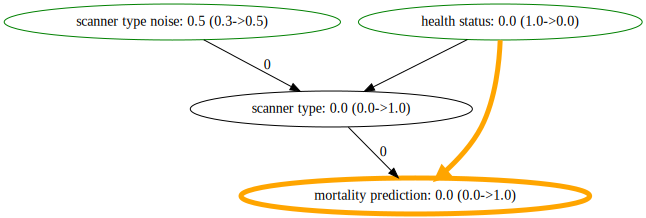

assign 0 credits to health status->mortality prediction


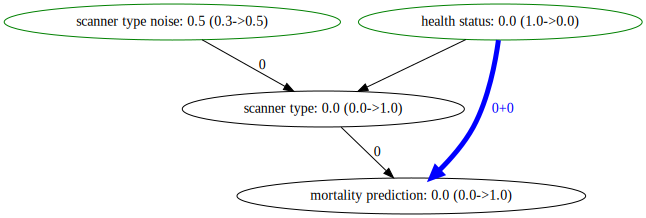

turn on edge health status->scanner type
scanner type changes from 0 to 1


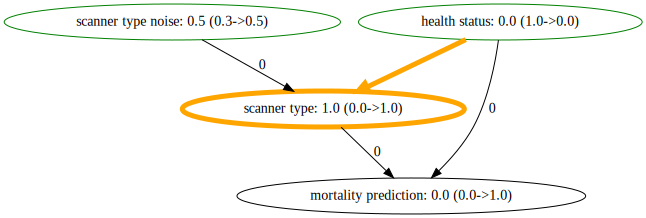

turn on edge scanner type->mortality prediction
mortality prediction changes from 0 to 1


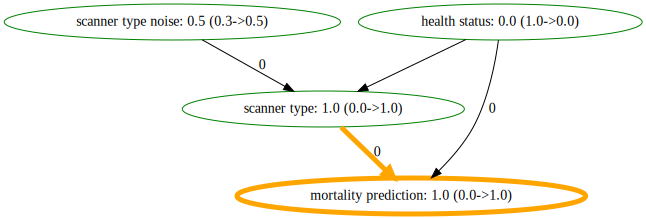

assign 1 credits to scanner type->mortality prediction


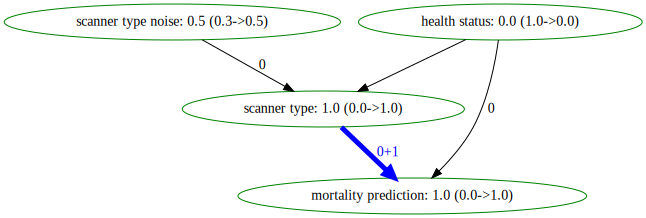

assign 1 credits to health status->scanner type


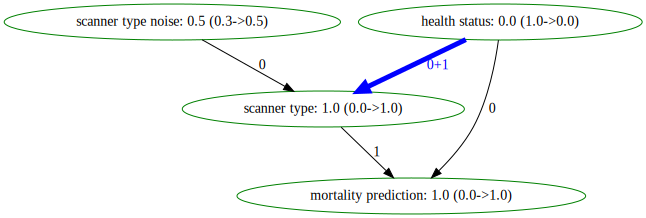

sampling: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


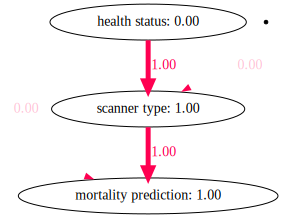

In [3]:
def build_health_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph: x1->x2, y = f(x1, x2)
    x1 = Node('health status')
    n2 = Node('scanner type noise', is_noise_node=True)
    
    x2 = Node('scanner type', lambda x1, n2: (0.9 > n2 if x1 <= 0.1 else 0.3 > n2).astype(int), [x1, n2])
    y  = Node('mortality prediction', lambda x1, x2: x2, 
              [x1, x2], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([x1, n2, x2, y],
                 {
                     'health status': lambda: 1,
                     'scanner type noise': lambda: 0.3 # np.random.uniform(0, 1)
                 },
                 {
                     'health status': lambda: 0,
                     'scanner type noise': lambda: 0.5 # np.random.uniform(0, 1),
                 })
   
    return graph

graph = build_health_graph()
verbose = True
cf = CreditFlow(graph, verbose=verbose, nruns=1, visualize=verbose)
cf.run()

cf.draw()

sampling: 100%|██████████| 1000/1000 [00:00<00:00, 5393.42it/s]


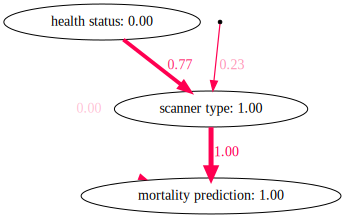

In [4]:
'''
current value: health status, scanner type, mortality
{
    (0, 1, 1): [(0-1, 0-0.89999)]
    (0, 0, 0): [(0-1. 0.9-1)]
}

to make sure value changes from (1, 0, 0) -> (0, 1, 1)
we need baseline noise 0.3-1
        target noise 0-0.899999
'''

def build_health_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph: x1->x2, y = f(x1, x2)
    x1 = Node('health status')
    n2 = Node('scanner type noise', is_noise_node=True)
    x2 = Node('scanner type', lambda x1, n2: (0.9 > n2 if x1 <= 0.1 else 0.3 > n2).astype(int), [x1, n2])
    y  = Node('mortality prediction', lambda x1, x2: x2, 
              [x1, x2], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([x1, n2, x2, y],
                 {
                     'health status': lambda: 1,
                     'scanner type noise': lambda: np.random.uniform(0.3, 1)
                 },
                 {
                     'health status': lambda: 0,
                     'scanner type noise': lambda: np.random.uniform(0, 0.9),
                 })
   
    return graph

graph = build_health_graph()
cf = CreditFlow(graph, verbose=False, nruns=1000)
cf.run()

cf.draw()

Health status has limited effect in this case when

1. target noise < 0.3 (health status has no effect when applied second)
2. base noise > 0.9 (health status has no effect when applied first)

which has probablity $1/3 * 1/2 + 1/7 * 1/2 = 0.238$, matching the result we saw here in simulation.

# More realistic setup

sampling: 100%|██████████| 1000/1000 [00:00<00:00, 5289.23it/s]


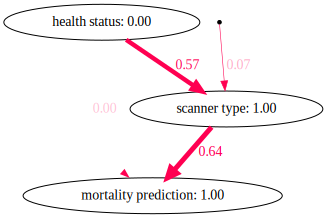

In [5]:
def build_health_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph: x1->x2, y = f(x1, x2)
    x1 = Node('health status')
    n2 = Node('scanner type noise', is_noise_node=True)
    x2 = Node('scanner type', lambda x1, n2: (0.9 > n2 if x1 <= 0.1 else 0.3 > n2).astype(int), [x1, n2])
    y  = Node('mortality prediction', lambda x1, x2: x2, 
              [x1, x2], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([x1, n2, x2, y],
                 {
                     'health status': lambda: np.random.choice([0, 1], p=[0.1, 0.9]),
                     'scanner type noise': lambda: np.random.uniform(0, 1) # relax baseline
                 },
                 {
                     'health status': lambda: 0,
                     'scanner type noise': lambda: np.random.uniform(0, 0.9), # target is invariant
                 })
   
    return graph

graph = build_health_graph()
cf = CreditFlow(graph, verbose=False, nruns=1000)
cf.run()

cf.draw()

# Demonstrating a causal understanding of the system by taking a test with cheatsheet

sampling: 100%|██████████| 300/300 [00:00<00:00, 2696.49it/s]


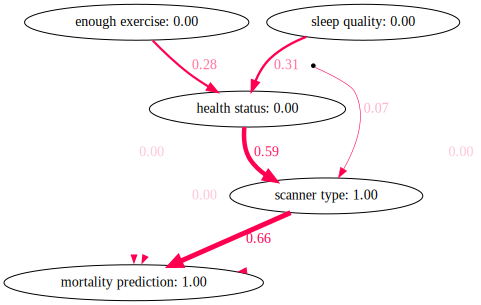

In [6]:
def build_health_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph: x1->x2, y = f(x1, x2)
    x00 = Node('enough exercise') # [0, 1]
    x01 = Node('sleep quality') # [0, 1]
    x1 = Node('health status', lambda x00, x01: x00 and x01, [x00, x01])
    n2 = Node('scanner type noise', is_noise_node=True)
    x2 = Node('scanner type', lambda x1, n2: (0.9 > n2 if x1 <= 0.1 else 0.3 > n2).astype(int), [x1, n2])
    y  = Node('mortality prediction', lambda x00, x01, x1, x2: x2, 
              [x00, x01, x1, x2], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([x00, x01, x1, n2, x2, y],
                 {
                      'enough exercise': lambda: 1,
                      'sleep quality': lambda: 1, 
                     #'health status': lambda: np.random.choice([0, 1], p=[0.1, 0.9]),
                     'scanner type noise': lambda: np.random.uniform(0, 1) # relax baseline
                 },
                 {
                      'enough exercise': lambda: 0,
                      'sleep quality': lambda: 0,
                     #'health status': lambda: 0,
                     'scanner type noise': lambda: np.random.uniform(0, 0.9), # target is invariant
                 })
   
    return graph

graph = build_health_graph()
# graph = boundary_graph(graph)
cf = CreditFlow(graph, verbose=False, nruns=300)
cf.run()

cf.draw()

sampling: 100%|██████████| 300/300 [00:00<00:00, 3224.52it/s]


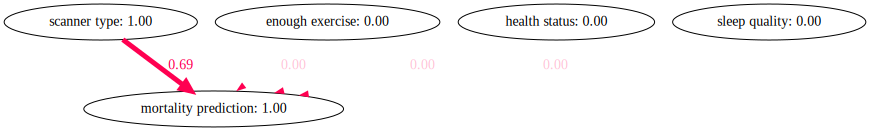

In [7]:
shap_graph = flatten_graph(graph)
verbose = False
cf = CreditFlow(shap_graph, verbose=verbose, nruns=300, visualize=verbose)
cf.run()

cf.draw()

sampling: 100%|██████████| 300/300 [00:00<00:00, 2073.97it/s]


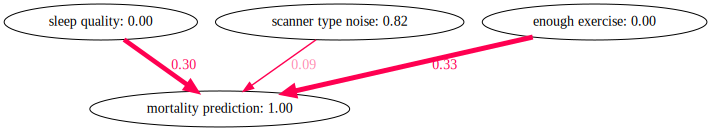

In [8]:
bgraph = boundary_graph(graph)
verbose = False
cf = CreditFlow(bgraph, verbose=verbose, nruns=300, visualize=verbose, fold_noise=False)
cf.run()

cf.draw()

In [9]:
print('fix other variables but only change health status')
sources = get_source_nodes(graph)
d = dict((node.name, 1) for node in sources)
d.update({'health status': 0, 'scanner type noise': 0.4})
print(d)
print('output:', eval_graph(graph, d))

sources = get_source_nodes(graph)
d = dict((node.name, 1) for node in sources)
d.update({'health status': 1, 'scanner type noise': 0.4})
print(d)
print('output:', eval_graph(graph, d))

fix other variables but only change health status
{'scanner type noise': 0.4, 'enough exercise': 1, 'sleep quality': 1, 'health status': 0}
output: [1]
{'scanner type noise': 0.4, 'enough exercise': 1, 'sleep quality': 1, 'health status': 1}
output: [0]


Health status clearly affect the output. However, in SHAP and ASV, its contribution is 0. 

## Possible presentation in paper for this synthetic experiment:

#### Flaws with ASV and SHAP

1. ASV and Shap give no credit to intermediate variables
2. However, if we intervenue on those variables (fix others being the same), we observe non-trivial change in output prediction
3. This questions how credit assignment should work

Should a variable move credit from its downstream features to its upstream causes? If we answer no, we are dismissing the good arguments for on data manifold perturbations. If we answer yes, we lose sight of actual features that affect the model, which is dangenerous if the model is actually using unstable correlation. It is critical to see all views of a model.

Also, ASV has no unique solution.

#### Aside from axioms, why Shapley flow is good?

We can demonstrate user understanding by letting them taking a test with cheat sheet.

The questions we ask them are counterfactual questions of the form: Given a particular configuration of foreground and background values of variables, how will the prediction change if we toggle the state of that variable?

The users should be allowed to prepare for this question to a) play with the system (given the model and the generative model) for 30 minutes b) providing them with a single viewpoint c) providing them with shapley flow. Then we can test their understanding by randomly generating those counterfactual questions. 

# Why it is tricky to assign credit to upstream nodes given downstream node

Here we show why credit assignment to upstream nodes are hard even if one uses feature clustering https://github.com/slundberg/shap/blob/master/notebooks/plots/bar.ipynb

### Ambiguity of causal graph with more than 1 incoming edges

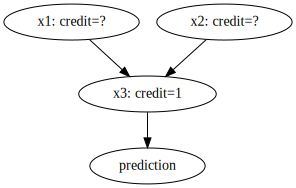

In [10]:
dot = Digraph()
dot.node('1', 'x1: credit=?')
dot.node('2', 'x2: credit=?')
dot.node('3', 'x3: credit=1')
dot.node('y', 'prediction')
dot.edges(['13', '23', '3y'])
dot

Given the credit the boundary node x3, it is not clear how we can assign credit to x1 and x2. To do that, one need to account for the functional dependence of x3 from x1 and x2. A side note is that if x1 and x2 are correlated, the functional form may not even be trusted. However, it just means that there are unmodeled hidden confounder that we should model. Another argument against learning a causal model is the unreliability of the data (may pick up on proxy variables). This point is equally true to any system that try to account for correlation.

This wouldn't be a problem if the causal graph is a tree. However, a causal tree would suffer nevertheless suffer from the following problem.

### Ambiguity of credit assignment when viewd from different perspectives

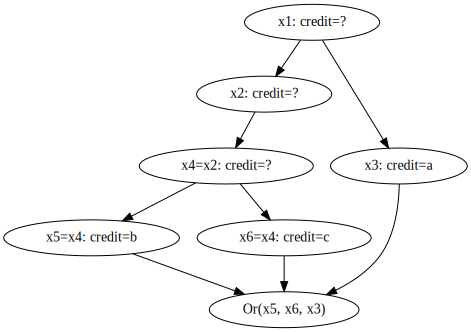

In [11]:
dot = Digraph()
dot.node('1', 'x1: credit=?')
dot.node('2', 'x2: credit=?')
dot.node('3', 'x3: credit=a')
dot.node('4', 'x4=x2: credit=?')
dot.node('5', 'x5=x4: credit=b')
dot.node('6', 'x6=x4: credit=c')
dot.node('y', 'Or(x5, x6, x3)')
dot.edges(['12', '13', '24', '45', '46', '5y', '6y', '3y'])
dot

Assume the baseline for x1, x2, x3, x4, x5, and x6 are all 0, and the foreground value for them are all 1s, then intuitively one would attempt to make a=b=c, and tracing the credit back to make x2 have credit of $b+c$. The result would be x2 have 2 times more credit compared to x3. However, it seems equally valid to argue that x2 and x3 should have the same credit because the computational graph can be equivalently written as:

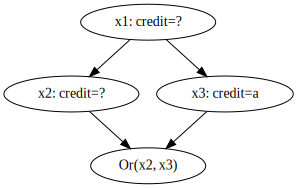

In [12]:
dot = Digraph()
dot.node('1', 'x1: credit=?')
dot.node('2', 'x2: credit=?')
dot.node('3', 'x3: credit=a')
dot.node('y', 'Or(x2, x3)')
dot.edges(['12', '13', '2y', '3y'])
dot

# Respecting the input and output interface when expanding a downstream node

A simple graph


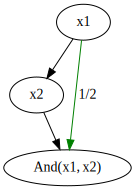

In [13]:
print('A simple graph')
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2')
dot.node('y', 'And(x1, x2)')

dot.edges(['12', '2y'])
dot.edge('1', 'y', color='green', label='1/2')
dot

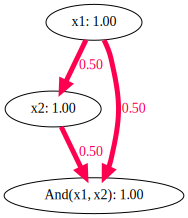

In [10]:
def build_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph
    x1 = Node('x1')
    x2 = Node('x2', lambda x1: x1, [x1])
    y  = Node('And(x1, x2)', lambda x1, x2: (x1 + x2 >= 2).astype(int), 
              [x1, x2], is_target_node=True)

    # initialize the values from data: now is just specified
    graph = Graph([x1, x2, y], 
              # sample baseline
              {'x1': lambda: 0, 'x2': lambda: 0, 'target': lambda: 0},
              # target to explain
              {'x1': lambda: 1, 'x2': lambda: 1, 'target': lambda: 1})

    return graph

graph = build_graph()
cf = CreditFlow(graph, verbose=False, nruns=-1)
cf.run(method='divide_and_conquer')

cf.draw()

adding an intermediate node from x1 to x2 (a seemingly valid way to expand out x2, but it fails to obey the input and output interface, note that x2 only takes one argument in the original graph)


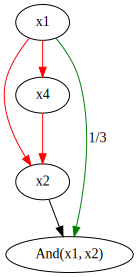

In [15]:
print('adding an intermediate node from x1 to x2 (a seemingly valid way to expand out x2, but it fails to obey the input and output interface, note that x2 only takes one argument in the original graph)')
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2')
# dot.node('3', 'x3')
dot.node('4', 'x4')
dot.node('y', 'And(x1, x2)')

dot.edges(['2y'])
dot.edge('1', 'y', color='green', label='1/3')
dot.edge('1', '4', color='red')
dot.edge('4', '2', color='red')
dot.edge('1', '2', color='red')
display(dot)

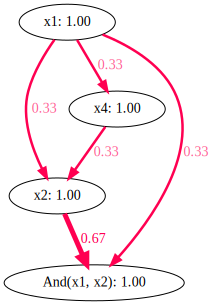

In [11]:
def build_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph
    x1 = Node('x1')
    x4 = Node('x4', lambda x1: x1, [x1])
    x2 = Node('x2', lambda x1, x4: (x4 + x1)/2, [x1, x4])
    y  = Node('And(x1, x2)', lambda x1, x2: (x1 + x2 >= 2).astype(int), 
              [x1, x2], is_target_node=True)

    # initialize the values from data: now is just specified
    graph = Graph([x1, x2, x4, y], 
              # sample baseline
              {'x1': lambda: 0, 'x2': lambda: 0, 'x4': lambda: 0, 'target': lambda: 0},
              # target to explain
              {'x1': lambda: 1, 'x2': lambda: 1,  'x4': lambda: 1, 'target': lambda: 1})

    return graph

graph = build_graph()
cf = CreditFlow(graph, verbose=False, nruns=-1)
cf.run(method='divide_and_conquer')

cf.draw()

A proper way to expand out x2 by adding a dummy input node


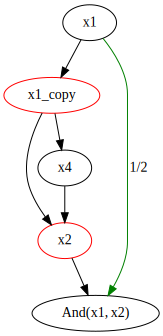

In [17]:
print('A proper way to expand out x2 by adding a dummy input node')
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2', color='red')
dot.node('3', 'x1_copy', color='red')
dot.node('4', 'x4')
dot.node('y', 'And(x1, x2)')

dot.edges(['2y'])
dot.edge('1', 'y', color='green', label='1/2')
dot.edge('1', '3')
dot.edge('3', '4')
dot.edge('4', '2')
dot.edge('3', '2')
dot

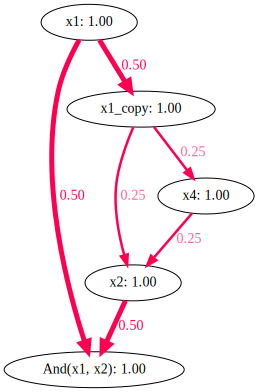

In [12]:
def build_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph
    x1 = Node('x1')
    x1_copy = Node('x1_copy', lambda x1: x1, [x1])
    x4 = Node('x4', lambda x1_copy: x1_copy, [x1_copy])
    x2 = Node('x2', lambda x1_copy, x4: (x4 + x1_copy) / 2, [x1_copy, x4])
    y  = Node('And(x1, x2)', lambda x1, x2: (x1 + x2 >= 2).astype(int), 
              [x1, x2], is_target_node=True)

    # initialize the values from data: now is just specified
    graph = Graph([x1, x2, x1_copy, x4, y], 
              # sample baseline
              {'x1': lambda: 0, 'x2': lambda: 0, 'x4': lambda: 0, 'x1_copy': lambda: 0, 'target': lambda: 0},
              # target to explain
              {'x1': lambda: 1, 'x2': lambda: 1,  'x4': lambda: 1, 'target': lambda: 1, 'x1_copy': lambda: 1})

    return graph

graph = build_graph()
cf = CreditFlow(graph, verbose=False, nruns=-1)
cf.run(method='divide_and_conquer')

cf.draw()

# Violating implementation invariance (upstream and downstream invariance)

For a reason why this would fail, refer to sanity check graphs notebook for an impossibility proof. 

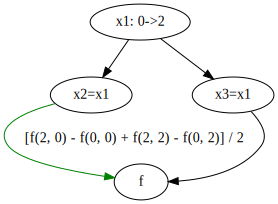

In [19]:
dot = Digraph()
dot.node('1', 'x1: 0->2')
dot.node('2', 'x2=x1')
dot.node('3', 'x3=x1')
dot.node('y', 'f')

dot.edges(['12', '13', '3y'])
dot.edge('2', 'y', color='green', label='[f(2, 0) - f(0, 0) + f(2, 2) - f(0, 2)] / 2')
dot

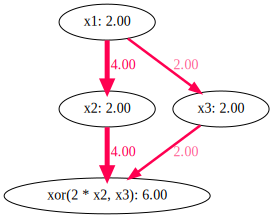

In [13]:
def xor(a, b):
    '''tenary representation of single digits a and b; default to 0'''
    return np.bitwise_xor(a.astype(int), b.astype(int))

def build_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph
    x1 = Node('x1')
    x2 = Node('x2', lambda x1: x1, [x1])
    x3 = Node('x3', lambda x1: x1, [x1])
    y  = Node('xor(2 * x2, x3)', lambda x2, x3: xor(2 * x2, x3), 
              [x2, x3], is_target_node=True)

    # initialize the values from data: now is just specified
    graph = Graph([x1, x2, x3, y], 
                  # sample baseline
                  {'x1': lambda: 0},
                  # target to explain
                  {'x1': lambda: 2})

    return graph

graph = build_graph()
cf = CreditFlow(graph, verbose=False, nruns=-1)
cf.run(method='divide_and_conquer')

cf.draw()

Expanding x1


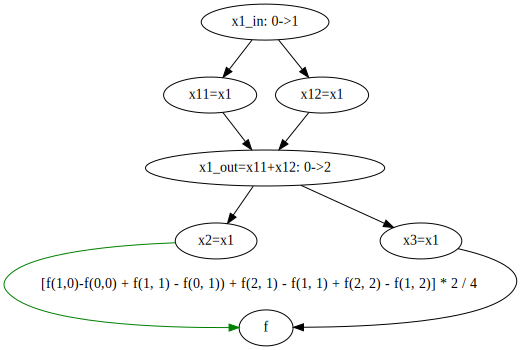

In [21]:
print('Expanding x1')
dot = Digraph()
dot.node('0', 'x1_in: 0->1')
dot.node('m', 'x11=x1')
dot.node('n', 'x12=x1')
dot.node('1', 'x1_out=x11+x12: 0->2')
dot.node('2', 'x2=x1')
dot.node('3', 'x3=x1')
dot.node('y', 'f')

dot.edges(['0m', '0n', 'n1', 'm1', 
           '12', '13', '3y'])
dot.edge('2', 'y', color='green', label='[f(1,0)-f(0,0) + f(1, 1) - f(0, 1)) + f(2, 1) - f(1, 1) + f(2, 2) - f(1, 2)] * 2 / 4')
dot

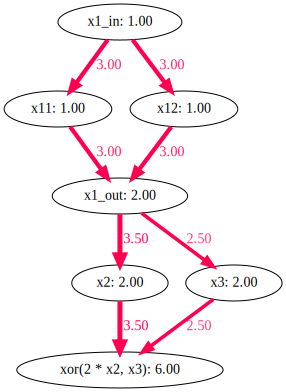

In [14]:
def build_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph
    x1_in = Node('x1_in')
    x11 = Node('x11', lambda x1: x1, [x1_in])
    x12 = Node('x12', lambda x1: x1, [x1_in])
    x1_out = Node('x1_out', lambda x11, x12: x11 + x12, [x11, x12])
    x2 = Node('x2', lambda x1: x1, [x1_out])
    x3 = Node('x3', lambda x1: x1, [x1_out])
    y  = Node('xor(2 * x2, x3)', lambda x2, x3: xor(2 * x2, x3), 
              [x2, x3], is_target_node=True)

    # initialize the values from data: now is just specified
    graph = Graph([x1_in, x11, x12, x1_out, x2, x3, y], 
                  # sample baseline
                  {'x1_in': lambda: 0},
                  # target to explain
                  {'x1_in': lambda: 1})

    return graph

graph = build_graph()
cf = CreditFlow(graph, verbose=False, nruns=-1)
cf.run(method='divide_and_conquer')

cf.draw()